In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

In [2]:
sns.set()

# Importando e entendendo os dados

In [3]:
file = pd.read_csv('weatherAUS.csv')

In [4]:
file.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
file['Date'] = pd.to_datetime(file['Date']) #Convertendo a data para o formato DateTIme

In [6]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

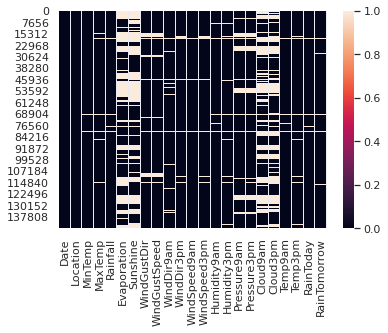

In [7]:
sns.heatmap(file.isnull());

Feito o heatmap observamos que 'Evaporation'e 'Sunshine' possum muitos dados faltantes, então terão que ser descartados

# Limpando os dados

In [8]:
file.drop(['Location','Evaporation','Sunshine','Cloud9am', 'Cloud3pm', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],axis=1, inplace=True)

Aqui retirei colunas com muitos dados faltantes, ou que seriam complicados de trabalhar como o WindDir e Location'

In [9]:
file_yes = file[file['RainToday'] == 'Yes'].copy()
file_no = file[file['RainToday'] == 'No'].copy()

In [10]:
for i in file_yes.columns[:-2]:
    mean = file_yes[i].mean()
    file_yes.update(file_yes[i].fillna(mean))
for i in file_no.columns[:-2]:
    mean = file_no[i].mean()
    file_no.update(file_no[i].fillna(mean))

Agora para tratar os restos dos dados, substituiremos os espaços faltantes pela média da coluna com referência de chuva 'RainToday', pois como sabemos a chuva influencia nos fatores de temperatura, humidade e etc... Não seria tão efetivo utilizar a média do conjunto completo

In [11]:
file = pd.concat([file_yes,file_no])

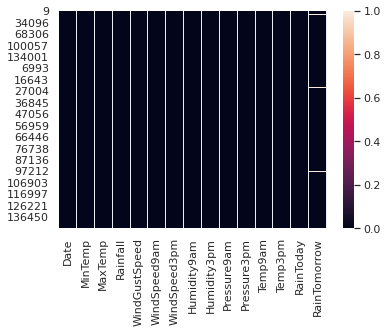

In [12]:
sns.heatmap(file.isnull()); #Feito

Após a remoção e tratamento de dados vamos para a visualização

# Análise dos Dados

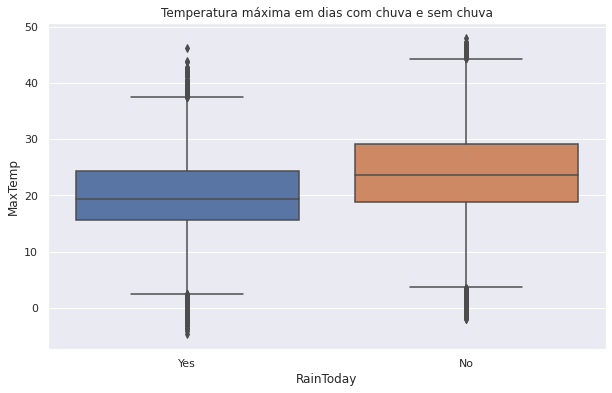

In [13]:
plt.figure(figsize=(10,6))
plt.title('Temperatura máxima em dias com chuva e sem chuva')
sns.boxplot(x='RainToday', y='MaxTemp', data=file);

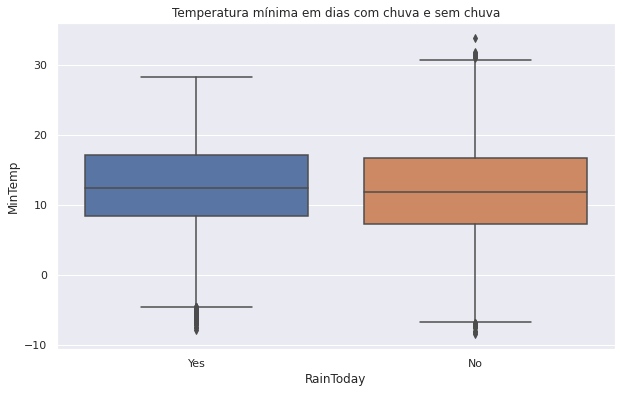

In [14]:
plt.figure(figsize=(10,6))
plt.title('Temperatura mínima em dias com chuva e sem chuva')
sns.boxplot(x='RainToday', y='MinTemp', data=file);

In [15]:
file['Month'] = pd.DatetimeIndex(file['Date']).month
file['Year'] = pd.DatetimeIndex(file['Date']).year

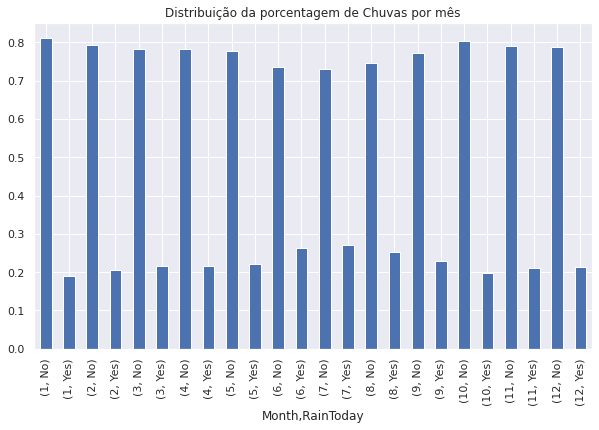

In [16]:
plt.figure(figsize=(10,6))
file.groupby('Month')['RainToday'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribuição da porcentagem de Chuvas por mês');

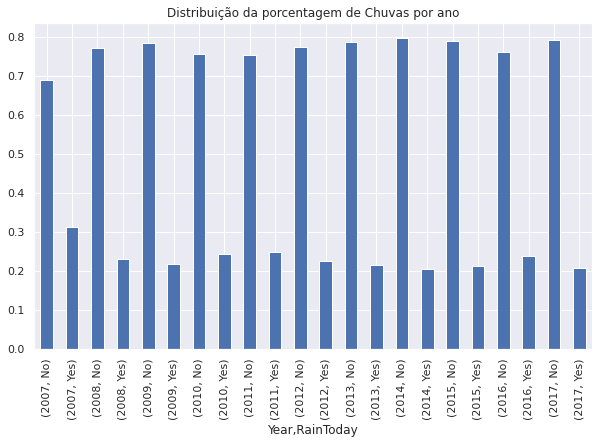

In [17]:
plt.figure(figsize=(10,6))
file.groupby('Year')['RainToday'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribuição da porcentagem de Chuvas por ano');

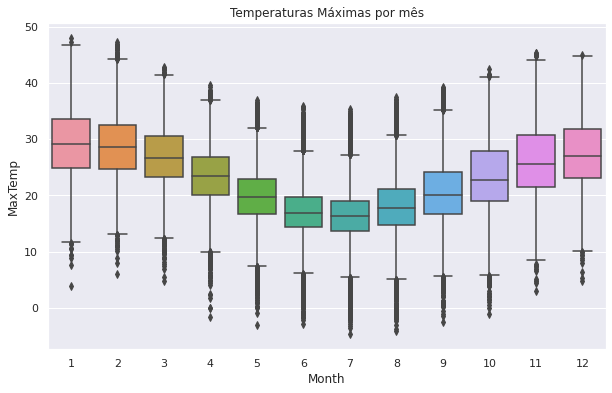

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Month', y='MaxTemp', data=file)
plt.title('Temperaturas Máximas por mês');

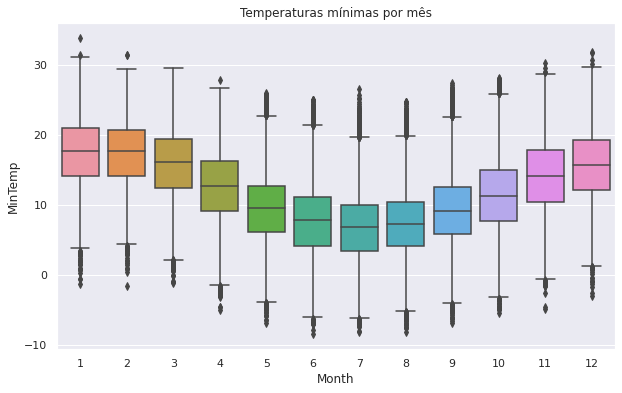

In [19]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Month', y='MinTemp', data=file)
plt.title('Temperaturas mínimas por mês');

Aqui podemos inferir que o País é predominantemente quente, com o verão de Novembro a Fevereiro, que é quando temos uma maior temperatura, além disso o maior volume de chuvas se dá nos meses de Junho, Julho e Agosto, que também são os meses com menores maximas e mínimas

# Preparação do Modelo de Machine Learning

Com certeza a remoção de outliars será o maior desafio, pois como estamos analizando o país como um todo naturalmente vai haver uma distribuição irregular como vemos nos boxplots de max/min por mês. Então vou utilizar como base a distribuição de máximas e mínimas geral que vimos no começo da análise de dados. Vamos de certa forma excluir os locais mais quentes e mais frios

In [20]:
def out_rem(dataset, column):
    """Remove dados acima do quantil 0.95 e abaixo do quantil 0.05 e retorna o novo dataset"""
    max_tresh = dataset[column].quantile(0.95)
    min_tresh = dataset[column].quantile(0.05)
    df = dataset[(dataset[column] < max_tresh) & (dataset[column] > min_tresh)]
    return df

In [21]:
file_yes = out_rem(file_yes,'MaxTemp')
file_no  = out_rem(file_no,'MaxTemp')

In [22]:
file = pd.concat([file_yes,file_no])

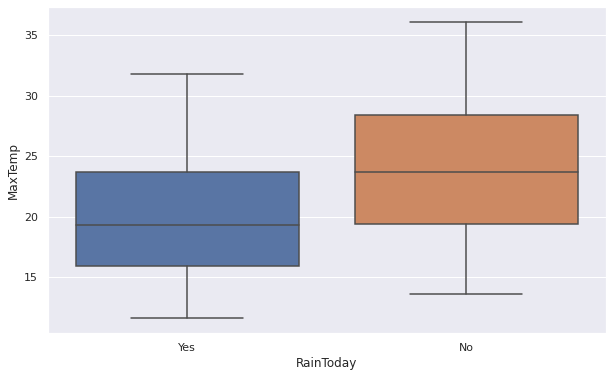

In [23]:
plt.figure(figsize=(10,6))
sns.boxplot(x='RainToday', y='MaxTemp', data=file);#feito

In [24]:
file['RainTomorrow'].isnull().value_counts()

False    126444
True       1278
Name: RainTomorrow, dtype: int64

Não tentarei tratar os dados faltantes de 'RainTomorrow' pois isso necessitaria da coluna 'Local' que abandonamos no começo, no entanto não seria tão complicado tratar esses dados, visto que temos a coluna 'RainToday' completa, então bastaria achar o dia e local em que não temos a informação 'RainTomorrow', e olha o 'RainToday' do dia seguinte


In [25]:
file.dropna(axis=0,inplace=True)

In [26]:
file['RainToday'] = pd.get_dummies(file['RainToday'],drop_first=True)
file['RainTomorrow'] = pd.get_dummies(file['RainTomorrow'],drop_first=True)

In [27]:
X = (file.drop(['Date','RainTomorrow'],axis=1))
y = file['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=19)

# Modelos

Um modelo de séries temporais não será viável pois como as informações vem de cidades diferentes, haverão dias em que choveu em uma cidade, mas não choveu em outra.

Vamos trabalhar com modelos supervisionados de classificação, e o logistic regression que trabalha muito bem para prever resultados resumidos a 0 ou 1

Admitiremos 0 como sem chuva no Dia seguinte, e 1 com chuva

In [28]:
logisticModel = LogisticRegression(max_iter=1000)

In [29]:
logisticModel.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [30]:
logistic_prediction = logisticModel.predict(X_test)

In [31]:
print(classification_report(y_test,logistic_prediction, target_names = ['Não chove','Chove']))
print(confusion_matrix(y_test,logistic_prediction))

              precision    recall  f1-score   support

   Não chove       0.86      0.95      0.90     19717
       Chove       0.73      0.46      0.56      5572

    accuracy                           0.84     25289
   macro avg       0.80      0.71      0.73     25289
weighted avg       0.83      0.84      0.83     25289

[[18771   946]
 [ 3015  2557]]


In [32]:
forestModel = RandomForestClassifier(n_estimators=350)

In [33]:
forestModel.fit(X_train,y_train)

RandomForestClassifier(n_estimators=350)

In [34]:
forest_prediction = forestModel.predict(X_test)

In [35]:
print(classification_report(y_test, forest_prediction, target_names = ['Não chove','Chove']))
print(confusion_matrix(y_test,forest_prediction))

              precision    recall  f1-score   support

   Não chove       0.87      0.95      0.91     19717
       Chove       0.75      0.49      0.59      5572

    accuracy                           0.85     25289
   macro avg       0.81      0.72      0.75     25289
weighted avg       0.84      0.85      0.84     25289

[[18802   915]
 [ 2836  2736]]


In [36]:
xgbModel = XGBClassifier(n_estimators=2000,learning_rate=0.05, n_jobs=4, use_label_encoder=False)

In [37]:
xgbModel.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], eval_metric='logloss', verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [38]:
xgb_prediction = xgbModel.predict(X_test)

In [39]:
print(classification_report(y_test, xgb_prediction, target_names = ['Não chove','Chove']))
print(confusion_matrix(y_test,xgb_prediction))

              precision    recall  f1-score   support

   Não chove       0.87      0.95      0.91     19717
       Chove       0.74      0.50      0.60      5572

    accuracy                           0.85     25289
   macro avg       0.81      0.72      0.75     25289
weighted avg       0.84      0.85      0.84     25289

[[18762   955]
 [ 2807  2765]]


Obtivemos até que uma boa performance dos modelos, principalmente em dias sem chuva pois são a maioria esmagadora do conjunto. De toda forma a acurácia dos modelos está na faixa dos 85% o que não é algo ruim